# 6.2 Keras로 MF 구현하기

In [1]:
# csv 파일에서 불러오기
import  pandas as pd

# train set과 test set을 나누기 위한 라이브러리
from sklearn.model_selection import train_test_split

# 필요한 tensorflow 모듈들을 가져온다.
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

# DataFrame 형태로 데이터를 읽어온다.
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./Data/u.data',
                        names=r_cols,
                        sep='\t',
                        encoding='latin-1')

ratings_train, ratings_test = train_test_split(ratings,
                                                test_size=0.2,
                                                shuffle=True,
                                                random_state=2021)

In [2]:
K = 200

mu = ratings_train.rating.mean()

M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1      # bias_com의 크기 1을 감안하는 것!

def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))



In [3]:
user = Input(shape=(1,))
item = Input(shape=(1,))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [4]:
R = layers.dot([P_embedding, Q_embedding], axes=(2,2)) # k와 k끼리 연산을 하겠다.

R = layers.add([R, user_bias, item_bias])

R = Flatten()(R)

model = Model(inputs=[user, item], outputs=R) # input-layer-output
model.compile(
    loss=RMSE,
    optimizer=SGD(),
    metrics=[RMSE]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 200)       188800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 200)       336600      input_2[0][0]                    
______________________________________________________________________________________________

In [5]:
result = model.fit(
    x = [ratings_train.user_id.values,
    ratings_train.movie_id.values],
    y = ratings_train.rating.values - mu,
    epochs=60,
    batch_size=256,
    validation_data=(
        [ratings_test.user_id.values,
        ratings_test.movie_id.values],
        ratings_test.rating.values - mu
    )

)

Epoch 1/60
313/313 [==============================] - 1s 3ms/step - loss: 5.2655 - RMSE: 1.1256 - val_loss: 5.0018 - val_RMSE: 1.1168
Epoch 2/60
313/313 [==============================] - 1s 2ms/step - loss: 4.7762 - RMSE: 1.1235 - val_loss: 4.5428 - val_RMSE: 1.1148
Epoch 3/60
313/313 [==============================] - 1s 2ms/step - loss: 4.3446 - RMSE: 1.1217 - val_loss: 4.1378 - val_RMSE: 1.1130
Epoch 4/60
313/313 [==============================] - 1s 2ms/step - loss: 3.9638 - RMSE: 1.1198 - val_loss: 3.7805 - val_RMSE: 1.1114
Epoch 5/60
313/313 [==============================] - 1s 2ms/step - loss: 3.6280 - RMSE: 1.1182 - val_loss: 3.4653 - val_RMSE: 1.1098
Epoch 6/60
313/313 [==============================] - 1s 3ms/step - loss: 3.3315 - RMSE: 1.1168 - val_loss: 3.1872 - val_RMSE: 1.1084
Epoch 7/60
313/313 [==============================] - 1s 2ms/step - loss: 3.0700 - RMSE: 1.1151 - val_loss: 2.9419 - val_RMSE: 1.1071
Epoch 8/60
313/313 [==============================] - 1s 2ms/s

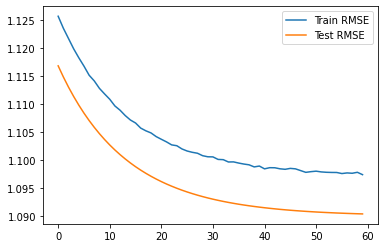

In [6]:
# plot RMSE
import matplotlib.pyplot as plt

plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label = 'Test RMSE')
plt.legend()
plt.show()

In [7]:
user_ids = ratings_test.user_id.values[0:6] # 적용해보기
movie_ids = ratings_test.movie_id.values[0:6]

predictions = model.predict([user_ids, movie_ids]) + mu #전체 평균 다시 더하기

In [8]:
print(ratings_test[0:6])

       user_id  movie_id  rating  timestamp
23307      468        51       3  875293386
36679       92       780       3  875660494
36626      555       489       5  879975455
83753      940        69       2  885921265
52604      181      1350       1  878962120
49877      320       195       5  884749255


In [9]:
print(predictions)

[[3.5550046]
 [3.4723089]
 [3.5492196]
 [3.5690255]
 [3.1871848]
 [3.5966241]]


In [10]:
import numpy as np

#RMSE 계산 

def RMSE2(y_true, y_pred):
  return np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2))

In [11]:
user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred,order="C") #1차원 형태로 바꿔줌.

y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

1.0913778530076552

# 6.3 딥러닝을 적용한 추천 시스템

In [13]:
import pandas as pd
import numpy as np

#train set과 test set을 나누기 위한 라이브러리
from sklearn.model_selection import train_test_split

#필요한 tensorflow 모듈들을 가져온다.
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

#layer 구성에 필요한 라이브러리 불러오기 
from tensorflow.keras.layers import Dense, Concatenate, Activation # 이 부분은 레이어 구성을 위해 필요한 리아브러리
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.optimizers import SGD, Adamax

#DataFrame 형태로 데이터를 읽어온다.
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./Data/u.data', names=r_cols,  sep='\t',encoding='latin-1')

ratings_train, ratings_test = train_test_split(ratings,
                                               test_size = 0.2,
                                               shuffle = True,
                                               random_state = 2021)
### Defining RMSE measure ###
# y_true, y_pred은 신경망에서 실제값, 예측값을 나타내는 Tensorflow/Keras 표준 변수
def RMSE(y_true, y_pred):
  # Tensorflow의 math클래스에 미리 정의된
  # 제곱근(sqrt), 평균(reduce_mean), 제곱(square) 함수를 통해 RMSE 계산
  return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))

### Variable 초기화 ###
#잠재요인 수 200으로 지정한다.
K = 200

#전체 평균 계산한다.
mu = ratings_train.rating.mean()

#사용자 아이디와 영화 아이디의 최댓값 -> 보통은 unique한 값의 개수 + 1로 해야함 
#1을 더하는 이유 : bias term 추가 고려
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

#################################################################################
#kreas 모델 
# 아래부분은 앞에서와 동일하게 사용자와 아이템 데이터를 embedding을 통해
# 각각 K개의 노드를 갖는 layer로 변환하고
# 사용자 bias와 아이템 bias를 1개의 노드를 갖는 layer로 변환한다.
user = Input(shape=(1,))
item = Input(shape=(1,))

#Embedding
P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user) #regularizer : 규제 -> 과적합 방지
Q_embedding = Embedding(N,K,embeddings_regularizer=l2())(item)

#bias
user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

#앞과 뒤를 한줄로 붙이기
# 이를 위해서 1자형으로 데이터를 만듦.
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])

R = Dense(2048)(R) #노드가 2048개인 하나의 layer를 만든 후 R과 연결 
R = Activation('linear')(R) # 위에 있는 Dense레이어를 activation function을 지정함.

R = Dense(256)(R)
R = Activation('linear')(R)

R = Dense(1)(R) #출력 layer

model = Model(inputs = [user,item],outputs=R)

model.compile(loss=RMSE,
    optimizer=SGD(), #Adamax도 가능
    metrics = [RMSE]
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 200)       188800      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 200)       336600      input_4[0][0]                    
____________________________________________________________________________________________

In [14]:
# Model fitting
# 모델 입력에 필요한 데이터 정리
train_user_ids = ratings_train.user_id.values
train_movie_ids = ratings_train.movie_id.values
train_ratings = ratings_train.rating.values

test_user_ids = ratings_test.user_id.values
test_movie_ids = ratings_test.movie_id.values
test_ratings = ratings_test.rating.values

#신경망 학습
result = model.fit(
    x = [train_user_ids, train_movie_ids],
    y = train_ratings - mu, #전체 평균 빼기 
    epochs = 65,
    batch_size = 512, #batch_size : 전체 train_set에서 512개씩 학습시키겠다.
    validation_data = (
        [test_user_ids, test_movie_ids],
         test_ratings - mu
    )
)

Epoch 1/65
157/157 [==============================] - 4s 20ms/step - loss: 5.3929 - RMSE: 1.1267 - val_loss: 5.2497 - val_RMSE: 1.1177
Epoch 2/65
157/157 [==============================] - 3s 20ms/step - loss: 5.1316 - RMSE: 1.1248 - val_loss: 4.9967 - val_RMSE: 1.1162
Epoch 3/65
157/157 [==============================] - 3s 21ms/step - loss: 4.8863 - RMSE: 1.1233 - val_loss: 4.7592 - val_RMSE: 1.1147
Epoch 4/65
157/157 [==============================] - 3s 20ms/step - loss: 4.6559 - RMSE: 1.1225 - val_loss: 4.5361 - val_RMSE: 1.1133
Epoch 5/65
157/157 [==============================] - 3s 20ms/step - loss: 4.4394 - RMSE: 1.1207 - val_loss: 4.3265 - val_RMSE: 1.1119
Epoch 6/65
157/157 [==============================] - 3s 20ms/step - loss: 4.2360 - RMSE: 1.1188 - val_loss: 4.1296 - val_RMSE: 1.1104
Epoch 7/65
157/157 [==============================] - 3s 21ms/step - loss: 4.0449 - RMSE: 1.1173 - val_loss: 3.9444 - val_RMSE: 1.1087
Epoch 8/65
157/157 [==============================] - 3

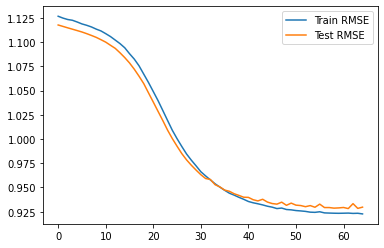

In [15]:
#plot RMSE
import matplotlib.pyplot as plt 
plt.plot(result.history['RMSE'], label = 'Train RMSE')
plt.plot(result.history['val_RMSE'], label = 'Test RMSE')
plt.legend()
plt.show()

# 6.4 딥러닝 모델에 변수 추가하기

In [19]:
# csv 파일에서 불러오기
import pandas as pd

#train set과 test set을 나누기 위한 라이브러리
from sklearn.model_selection import train_test_split

#필요한 tensorflow 모듈들을 가져온다.
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax
from tensorflow.keras.layers import Dense, Concatenate, Activation

### Defining RMSE measure ###
# y_true, y_pred은 신경망에서 실제값, 예측값을 나타내는 Tensorflow/Keras 표준 변수
def RMSE(y_true, y_pred):
  # Tensorflow의 math클래스에 미리 정의된
  # 제곱근(sqrt), 평균(reduce_mean), 제곱(square) 함수를 통해 RMSE 계산
  return tf.sqrt(tf.reduce_mean(tf.square(y_true-y_pred)))

#DataFrame 형태로 데이터를 읽어온다.
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('./Data/u.data', names=r_cols,  sep='\t',encoding='latin-1')

ratings_train, ratings_test = train_test_split(ratings,
                                               test_size = 0.2,
                                               shuffle = True,
                                               random_state = 2021)

#사용자(user) 데이터 가져오기 
u_cols = ["user_id","age",'sex',"occupation","zip_code"]
users = pd.read_csv('./Data/u.user',
                    sep = '|',
                    names = u_cols,
                    encoding='latin-1')
#사용자 ID와 직업만 남긴다.
users = users[['user_id','occupation']]

occupation = {} # 직업을 dict 형태로
def convert_occ(x):
  if x in occupation:
    return occupation[x]
  else: 
    occupation[x] = len(occupation) # 직업에 대해 인덱스를 부여 ex) {선생님 : 0}
    return occupation[x]

users['occupation'] = users['occupation'].apply(convert_occ)

L = len(occupation) # bias term이 없기 때문에 +1 필요 X

train_occ = pd.merge(ratings_train, users, on = 'user_id')['occupation']
test_occ = pd.merge(ratings_test, users, on = 'user_id')['occupation']

#잠재요인 수 
K = 200

#전체 평균 계산
mu = ratings_train.rating.mean()

#사용자 아이디와 영화 아이디의 최댓값 -> 보통은 unique한 값의 개수 + 1로 해야함 
#1을 더하는 이유 : bias term 추가 고려
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

#kreas 모델 
user = Input(shape=(1,))
item = Input(shape=(1,))

#Embedding
P_embedding = Embedding(M,K,embeddings_regularizer=l2())(user) #regularizer : 규제 -> 과적합 방지
Q_embedding = Embedding(N,K,embeddings_regularizer=l2())(item)

#bias
user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

#앞과 뒤를 한줄로 붙이기위해 Flatten 수행 
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)

user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

#직업 변수 추가 
occ = Input(shape = (1,))
OCC_embedding = Embedding(L,3, embeddings_regularizer=l2())(occ)
OCC_layer = Flatten()(OCC_embedding) 

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, OCC_layer])

R = Dense(2048)(R) #노드가 2048개인 하나의 layer를 만든 후 R과 연결 
R = Activation('linear')(R) 

R = Dense(256)(R)
R = Activation('linear')(R)

R = Dense(1)(R) #출력 layer

model = Model(inputs = [user, item, occ],outputs=R) # 직업이라는 변수가 추가됨.
model.compile(loss=RMSE,
              optimizer=SGD(), #Adamax도 가능
              metrics = [RMSE])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 200)       188800      input_5[0][0]                    
____________________________________________________________________________________________

In [20]:
# Model fitting
# 모델 입력에 필요한 데이터 정리
train_user_ids = ratings_train.user_id.values
train_movie_ids = ratings_train.movie_id.values
train_ratings = ratings_train.rating.values
train_occs = train_occ.values

test_user_ids = ratings_test.user_id.values
test_movie_ids = ratings_test.movie_id.values
test_ratings = ratings_test.rating.values
test_occs = test_occ.values

#신경망 학습
result = model.fit(
    x = [train_user_ids, train_movie_ids, train_occs],
    y =  train_ratings - mu, #전체 평균 빼기 
    epochs = 65,
    batch_size = 512, #batch_size : 전체 train_set에서 512개씩 학습시키겠다.
    validation_data = (
        [test_user_ids, test_movie_ids, test_occs],
        test_ratings- mu
    )
)


Epoch 1/65
157/157 [==============================] - 4s 21ms/step - loss: 5.3868 - RMSE: 1.1266 - val_loss: 5.2440 - val_RMSE: 1.1174
Epoch 2/65
157/157 [==============================] - 3s 20ms/step - loss: 5.1256 - RMSE: 1.1245 - val_loss: 4.9914 - val_RMSE: 1.1159
Epoch 3/65
157/157 [==============================] - 3s 20ms/step - loss: 4.8806 - RMSE: 1.1227 - val_loss: 4.7538 - val_RMSE: 1.1141
Epoch 4/65
157/157 [==============================] - 3s 21ms/step - loss: 4.6502 - RMSE: 1.1210 - val_loss: 4.5308 - val_RMSE: 1.1125
Epoch 5/65
157/157 [==============================] - 3s 21ms/step - loss: 4.4338 - RMSE: 1.1190 - val_loss: 4.3213 - val_RMSE: 1.1108
Epoch 6/65
157/157 [==============================] - 3s 20ms/step - loss: 4.2305 - RMSE: 1.1175 - val_loss: 4.1244 - val_RMSE: 1.1090
Epoch 7/65
157/157 [==============================] - 3s 20ms/step - loss: 4.0395 - RMSE: 1.1158 - val_loss: 3.9393 - val_RMSE: 1.1071
Epoch 8/65
157/157 [==============================] - 3

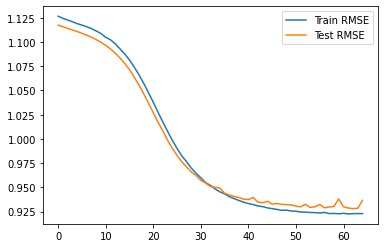

In [21]:
#plot RMSE
import matplotlib.pyplot as plt 
plt.plot(result.history['RMSE'], label = 'Train RMSE')
plt.plot(result.history['val_RMSE'], label = 'Test RMSE')
plt.legend()
plt.show()